## Padrões de escrita no código




- Nome de variável: nome_outro_nome (snake case)
- Nome de Função Nativa da API: Inglês, por exemplo: get_token (snake case)
- Nome de Função Criada para Aplicação: Português, por exemplo: buscar_informacoes (snake case)
- Nome de DataFrame: Começa com df, por exemplo, df_todos_albuns (snake case)



# <font color='pink'>***Instalando o a biblioteca do Spotipy***</font>



### Importando os pacotes necessários para tratamento e estatística


In [ ]:
# Instalando a biblioteca de Spotify
!pip install spotipy

In [ ]:
# importando as bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
import os
import base64
import json
import spotipy
from credencials import client_id, client_secret
from spotipy.oauth2 import SpotifyClientCredentials
from requests import post
from requests.api import get
from pickle import GET

# controlando os avisos
import warnings
warnings.filterwarnings('ignore')

#configurações do Pandas
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',100)



# <font color='pink'>***Spotify Client Credentials***</font>



In [ ]:
# Utilizando as credenciais para conectar a API
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# REQUISIÇÃO

In [ ]:
# Realiza o método GET para realizar a extração do Token de acesso
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = base64.b64encode(auth_bytes).decode("utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }

    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

# Realiza a autorização da conexão do token
def get_auth_header(token):
  return{"Authorization" : "Bearer " + token}


# Buscando o artista desejado e retorna apenas o nome e a conexão
# com o resultado em json do artista pelo ID do artista

def search_for_artist(token, artist_name):
  url = "https://api.spotify.com/v1/search"
  headers = get_auth_header(token)
  query = f"?q={artist_name}&type=artist&limit=1"

  query_url = url + query
  result = get(query_url, headers=headers)
  json_result = json.loads(result.content)["artists"]["items"]

  if len(json_result) == 0:
    print("No artist with this name exists....")
    return None
  return json_result[0]


# Buscando as canções mais populares de acordo com o Spotify
def get_top_10_songs(token, artist_id):
  url = f"http://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=BR"
  headers = get_auth_header(token)
  result = get(url, headers=headers)
  json_result = json.loads(result.content)["tracks"]
  return json_result


# Conexão com a API através do Cantor@
token = get_token()
result = search_for_artist(token, "Ludmilla")
artist_id = result["id"]


# <font color='pink'>***Tratamento de Dados***</font>

### Definindo datasets

In [ ]:
# Buscando todos os álbuns do artista
def buscar_informacoes(artist_id,album_type):
  all_albums = []
  offset = 0
  limit = 50
  while True:
      albums = sp.artist_albums(artist_id, album_type, limit=limit, offset=offset)

      if not albums['items']:
          break
      all_albums.extend(albums['items'])
      offset += limit
  for album in all_albums:
      print(album['name'])
  return all_albums



##<font color='green'>***Tratamento de dados do álbum***

In [ ]:
# atribuindo a um dataset e inserindo o parâmetro de álbum
df_todos_albuns = pd.DataFrame(buscar_informacoes(artist_id,'album'))

In [ ]:
# Verificação do dataframe antes do tratamento
df_todos_albuns.head()

In [ ]:
# Fatiando a renomeando as colunas do dataframe de todos os álbuns
df_todos_albuns = df_todos_albuns[['type','artists','available_markets','id','name','release_date','release_date_precision','total_tracks']]
df_todos_albuns.columns = ['tipo','artista','paises_disponiveis','id','musica','data_lancamento','precisao_lancamento','total_faixa']

#Tratamento para inserir apenas os nomes do artista na coluna "artist"
for i in range(len(df_todos_albuns['artista'])):
  for j in range(len(df_todos_albuns['artista'][i])):
    df_todos_albuns['artista'][i][j] = df_todos_albuns['artista'][i][j]['name']

In [ ]:
#verificando dataframe do álbum depois do tratamento
df_todos_albuns.head()

In [ ]:
#Pegando a descrição do álbum para total de faixa
df_todos_albuns.describe()

In [ ]:
# Trazendo todos os países
df_todos_paises = df_todos_albuns['paises_disponiveis']
df_todos_paises = pd.DataFrame(df_todos_paises)


# Use explode com index=False para manter o DataFrame plano
# O parâmetro ignore_index=True faz com que o índice seja redefinido após a explosão
df_todos_paises = df_todos_paises.explode('paises_disponiveis', ignore_index=True)

In [ ]:
df_todos_paises.head()

In [ ]:
#Visualizando os Estados/ Países
df_todos_albuns["paises_disponiveis"].value_counts().index

In [ ]:
contagem_de_estados = df_todos_albuns["paises_disponiveis"].value_counts().to_frame().reset_index()
contagem_de_estados.columns = ["paises_disponiveis", "total"]
contagem_de_estados

##<font color='green'>***Tratamento de dados do singles***

In [ ]:
# atribuindo a um dataset e inserindo o parâmetro de álbum
df_todos_singles = pd.DataFrame(buscar_informacoes(artist_id,'single'))

In [ ]:
# Fatiando a renomeando as colunas do dataframe de todos os singles
df_todos_singles = df_todos_singles[['type','artists','available_markets','id','name','release_date','release_date_precision','total_tracks']]
df_todos_singles.columns = ['tipo','artista','paises_disponiveis','id','musica','data_lancamento','precisao_lancamento','total_faixa']

#Tratamento para inserir apenas os nomes do artista na coluna "artist"
for i in range(len(df_todos_singles['artista'])):
  for j in range(len(df_todos_singles['artista'][i])):
    df_todos_singles['artista'][i][j] = df_todos_singles['artista'][i][j]['name']

In [ ]:
# Verificação do dataframe single
df_todos_singles.head()

In [ ]:
#Trazendo quantidades de artistas e de como está divido
contagem_de_artistas = df_todos_singles["artista"].value_counts().to_frame().reset_index()
contagem_de_artistas.columns = ["artista", "total"]
contagem_de_artistas

In [ ]:
#Verificando artista
df_todos_singles[['artista']].iloc[2]

artista    [Sorriso Maroto, LUDMILLA, Belo]
Name: 2, dtype: object

#Explorando Dados - Single

In [ ]:
df_todos_singles.isnull().sum()

In [ ]:
#Pegando info do DataFrame
df_todos_singles.info()

In [ ]:
df_todos_albuns.describe().transpose()

In [ ]:
#Fazendo contagem das músicas single
contagem_de_musica = df_todos_singles["musica"].value_counts().to_frame().reset_index()
contagem_de_musica.head()

In [ ]:
# Definindo o dataFrame dos Gêneros Musicais
genero_musical = pd.DataFrame(result['genres'])
genero_musical.head()

In [ ]:
#Top 10 músicas mais ouvida
top_10_musicas = df_todos_singles['musica'].value_counts().reset_index(name='contagem')

# Ordene o DataFrame pelo número de reproduções em ordem decrescente
top_10_musicas = top_10_musicas.sort_values(by='contagem', ascending=False)

# Selecione as 10 músicas mais ouvidas
top_10_musicas = top_10_musicas.head(10)

# Exiba o DataFrame resultante
print(top_10_musicas)

                                                index  contagem
0                                     Fala Mal de Mim         2
63                                    Solteiras Shake         1
73                                Me Espera (Ao Vivo)         1
72  Coração Deserto / Ninguém Merece Amar Sozinho ...         1
71                                          VILÃ LIVE         1
70                               Brigas Demais - Live         1
69                          Sintomas de Prazer - Live         1
68                                     Ritmo Do Crime         1
67                              Insegurança (Ao Vivo)         1
66                                         Zangadinha         1


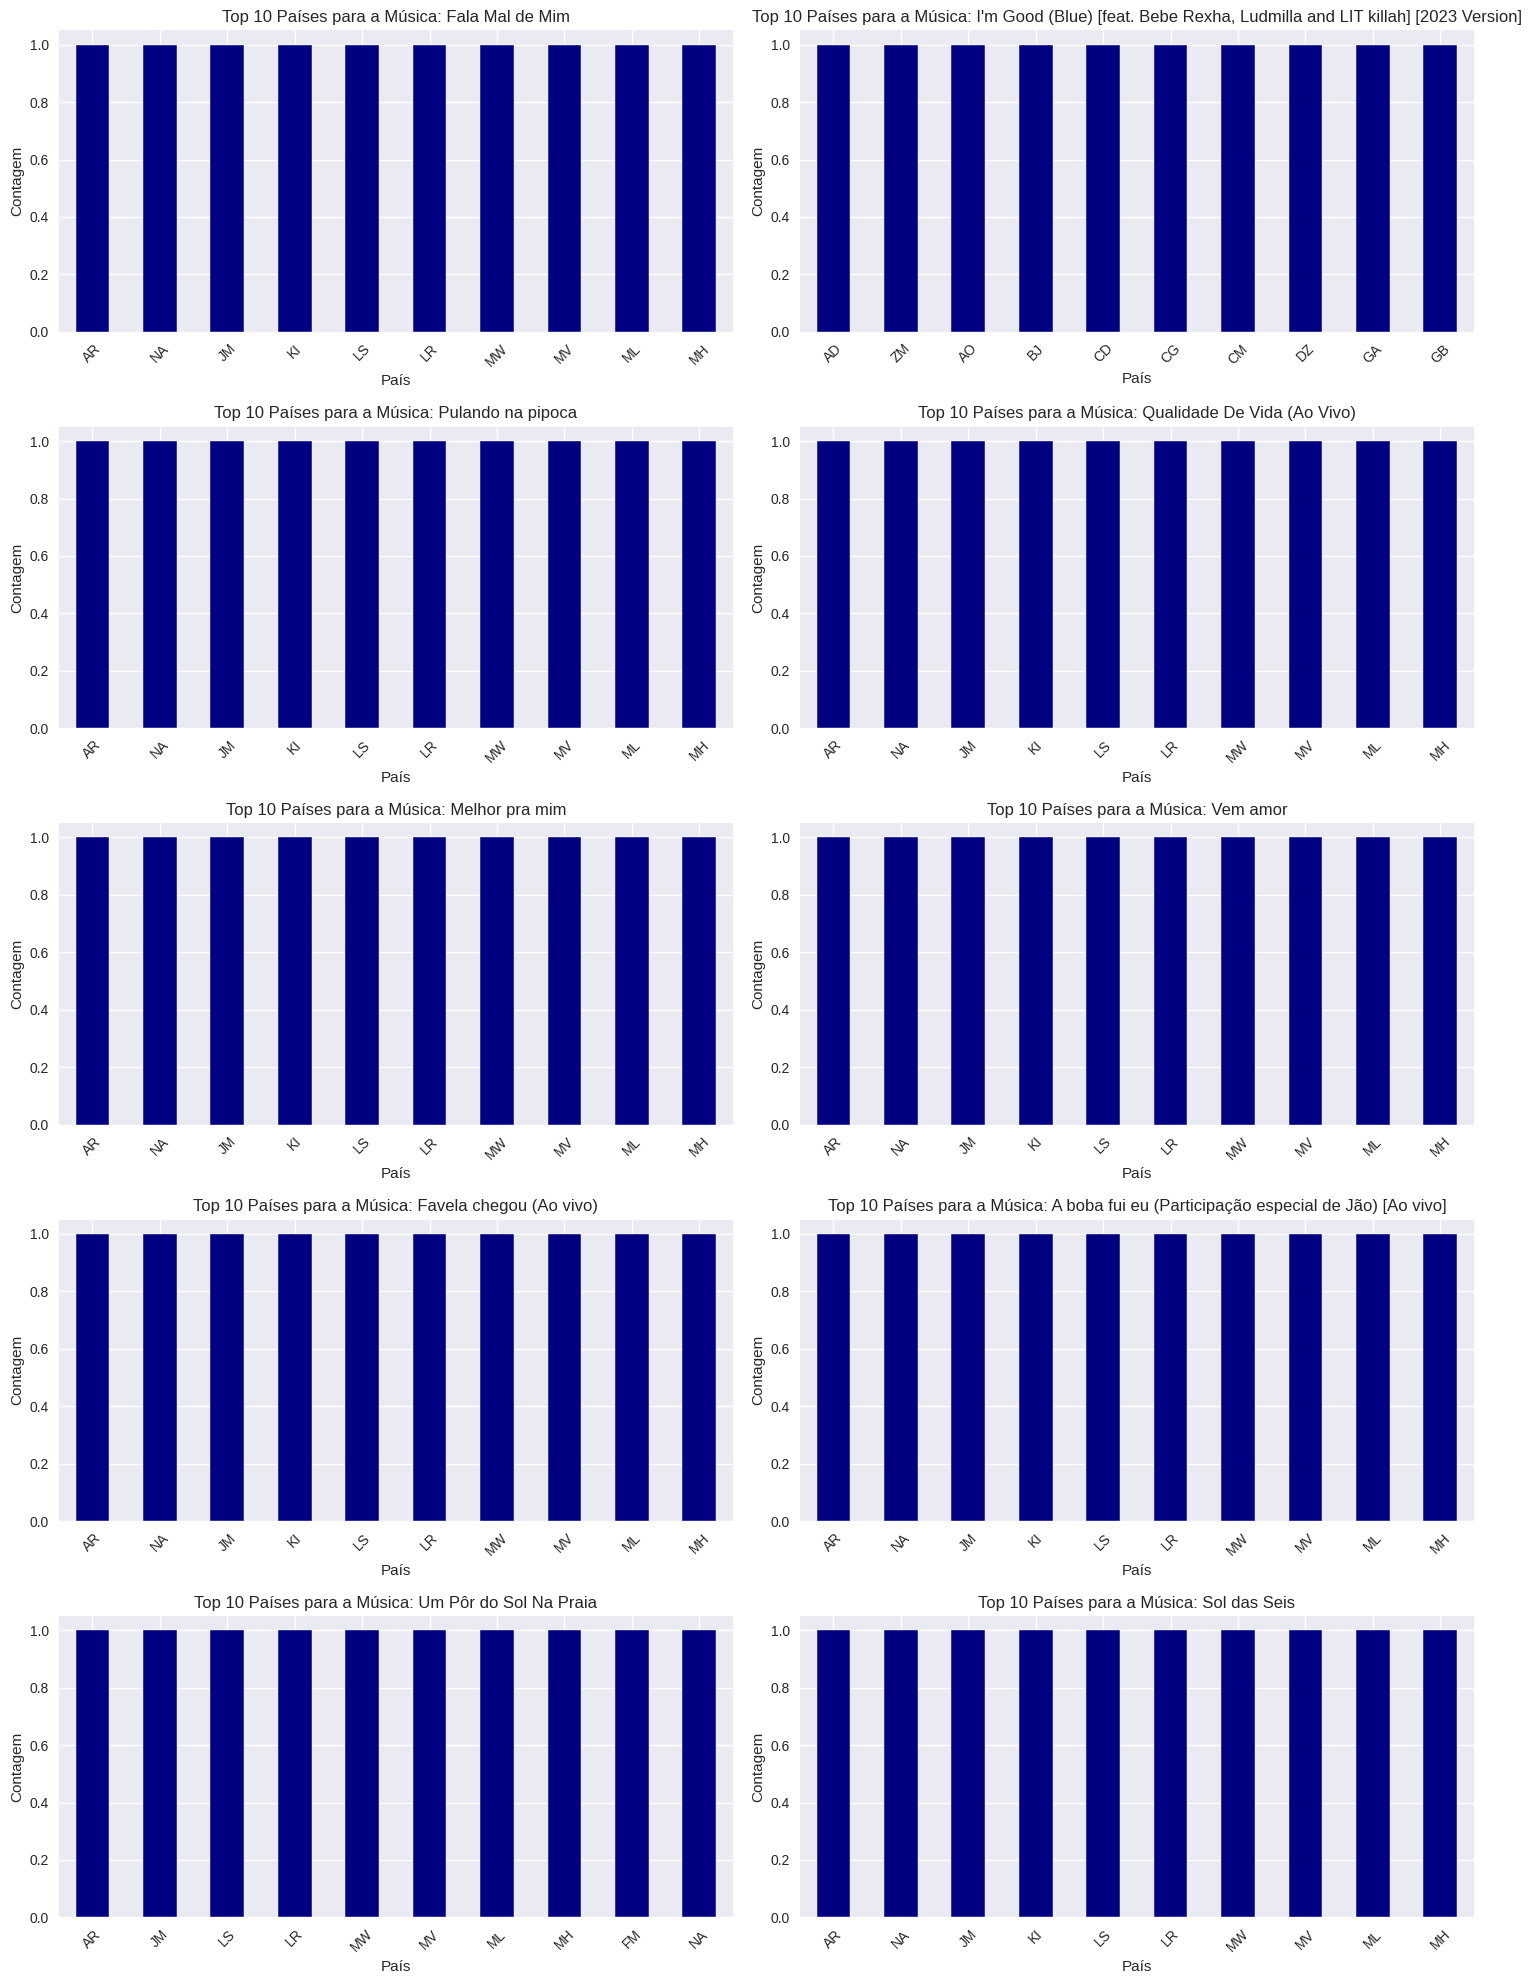

In [ ]:
# Obtém as 10 músicas mais ouvidas
top_10_musicas = df_todos_singles['musica'].value_counts().head(10).index

# Configura o tamanho da figura global
plt.figure(figsize=(15, 20))

# Loop pelas 10 músicas mais ouvidas
for i, musica in enumerate(top_10_musicas):
    # Obtém a lista de países para a música atual
    paises_da_musica = df_todos_singles[df_todos_singles['musica'] == musica]['paises_disponiveis'].values[0]

    # Conta a frequência de cada país na lista
    contagem_paises = pd.Series(paises_da_musica).value_counts()

    # Seleciona os top 10 países
    top_10_paises = contagem_paises.head(10)

    # Cria um subplot para cada música
    plt.subplot(5, 2, i + 1)
    top_10_paises.plot(kind='bar', color='navy')
    plt.title(f'Top 10 Países para a Música: {musica}')
    plt.xlabel('País')
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)

# Ajusta o layout global
plt.tight_layout()
plt.show()

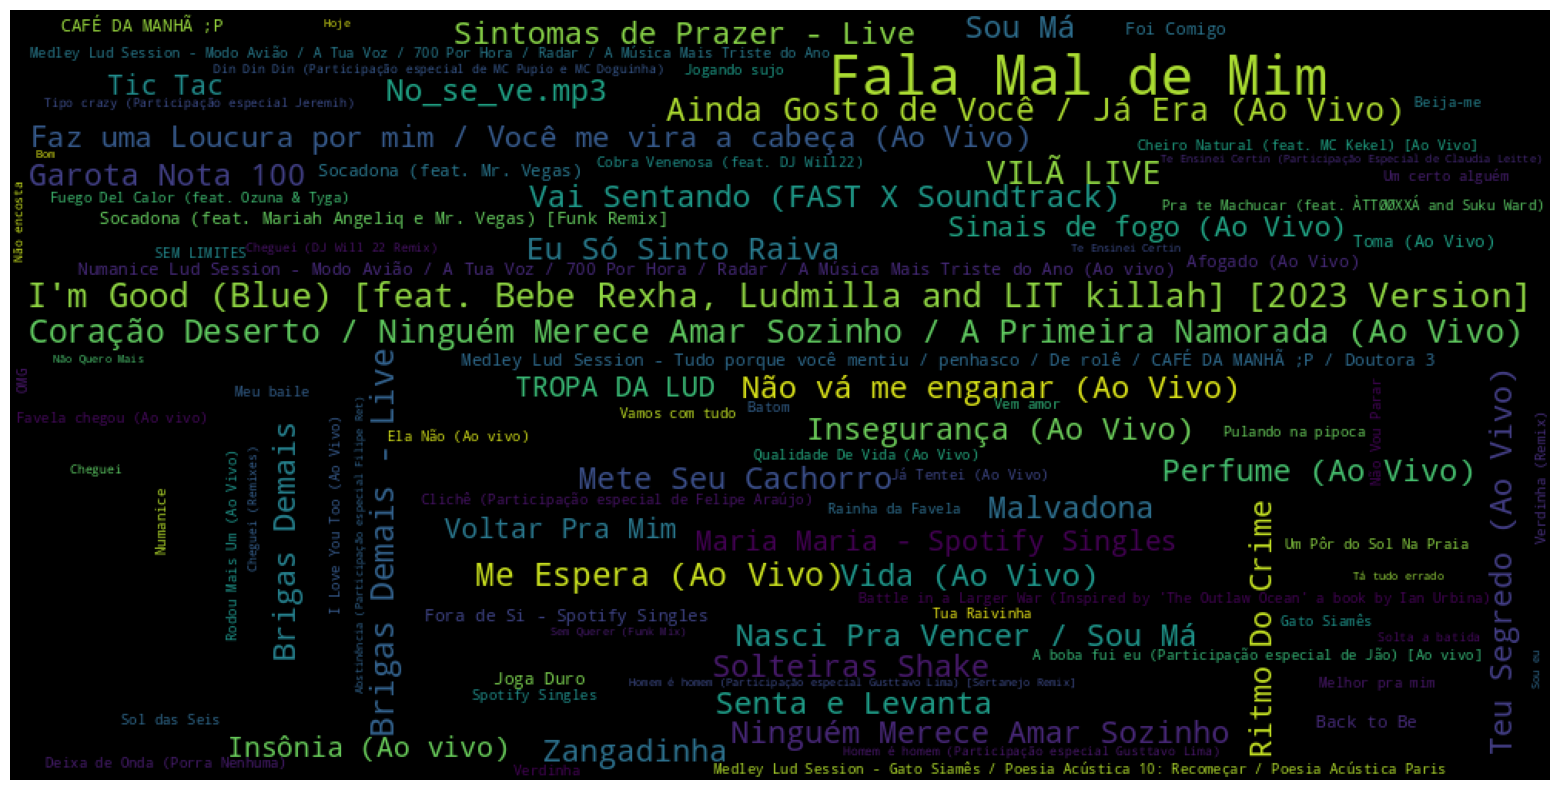

In [ ]:
#Nuvem de música
from wordcloud import WordCloud
from collections import Counter
todas_as_musicas = [faixa for faixa in df_todos_singles['musica']]
musica = Counter(todas_as_musicas)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(musica)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off');

#Teste - Single

In [ ]:
all_countries = [country for countries in df_todos_singles['paises_disponiveis'] for country in countries]
country_counts = sns.histplot(all_countries, kde=True, ax=ax[0], color="navy")
ax[0].set_xlabel("paises_disponiveis", fontsize=15)

Text(0.5, 1091.5032679738563, 'paises_disponiveis')

## DataFrame de Singles